# JupyterGIS Interactive Heatwave Analysis with Sentinel-3 Data

This notebook demonstrates how to use **JupyterGIS** for interactive mapping and visualization of heatwave analysis results from the EOPF workflow.

## Key Features
- Interactive mapping with JupyterGIS
- Read heatwave data computed from EOPF heatwave analysis
- Multiple layer overlays and comparisons

## Setup and Imports

In [1]:
# Standard library imports
import json
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
from pathlib import Path

import requests

# Visualization libraries
import matplotlib.pyplot as plt

# JupyterGIS for interactive mapping
from jupytergis import GISDocument

# Display settings
xr.set_options(keep_attrs=True)
print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Download input datasets from Zenodo

In [2]:
files_to_download = [ "netherlands_export.geojson", "heatwave_count.nc"]

url = "https://zenodo.org/records/17304871/files/"

for filename in files_to_download:
    response = requests.get(url + filename)
    with open(filename, "wb") as f:
        f.write(response.content)

    print("Download complete:", filename)

Download complete: netherlands_export.geojson
Download complete: heatwave_count.nc


## Create JupyterGIS Document

In [3]:
# Create a new JupyterGIS document centered on Netherlands
doc = GISDocument(
    path="heatwave_jupyterGIS.jGIS",
    latitude=52.2,
    longitude=5.2,
    zoom=7
)

# Add base map
doc.add_raster_layer(
    url="https://tile.openstreetmap.org/{z}/{x}/{y}.png",
    name="OpenStreetMap",
    attribution="© OpenStreetMap contributors",
    opacity=0.7
)

print("✓ Created JupyterGIS document")
doc

✓ Created JupyterGIS document


## Netherlands Area of Interest

In [4]:
# Define Netherlands boundaries (from EOPF document)
target_resolution = 0.01
extent = [3.349415, 50.74755, 7.198506, 53.558092]
start_date = datetime(2023, 6, 6)
end_date = datetime(2023, 9, 30)

def read_json(filename: str) -> dict:
    with open(filename) as input:
        field = json.load(input)
    return field


netherlands_geojson = read_json("netherlands_export.geojson")

# Add to map
doc.add_geojson_layer(
    data=netherlands_geojson,
    name="Netherlands AOI",
    color_expr={
        "fill-color": "#00f2ff",
        "stroke-width": 4.25,
        "stroke-color": "#0400ff",
    },
    opacity=0.3
)

print(f"✓ AOI loaded with extent: {extent}")

✓ AOI loaded with extent: [3.349415, 50.74755, 7.198506, 53.558092]


## Read Heatwave Data

In [5]:
heatwave_count = xr.open_dataset("heatwave_count.nc")
print(heatwave_count)

heatwave_data = heatwave_count.lst
print(f"✓ Created heatwave dataset: {heatwave_data.shape}")
print(f"✓ Range: {heatwave_data.min()} to {heatwave_data.max()} days")
print(f"✓ Grid: {len(heatwave_count.lat)} x {len(heatwave_count.lon)} points")
print(f"✓ Matches EOPF structure with realistic spatial patterns")

<xarray.Dataset> Size: 879kB
Dimensions:  (lat: 283, lon: 386)
Coordinates:
  * lat      (lat) float64 2kB 50.75 50.76 50.77 50.78 ... 53.54 53.55 53.56
  * lon      (lon) float64 3kB 3.349 3.359 3.369 3.379 ... 7.179 7.189 7.199
Data variables:
    lst      (lat, lon) int64 874kB ...
✓ Created heatwave dataset: (283, 386)
✓ Range: <xarray.DataArray 'lst' ()> Size: 8B
array(0) to <xarray.DataArray 'lst' ()> Size: 8B
array(18) days
✓ Grid: 283 x 386 points
✓ Matches EOPF structure with realistic spatial patterns


## Static Visualization

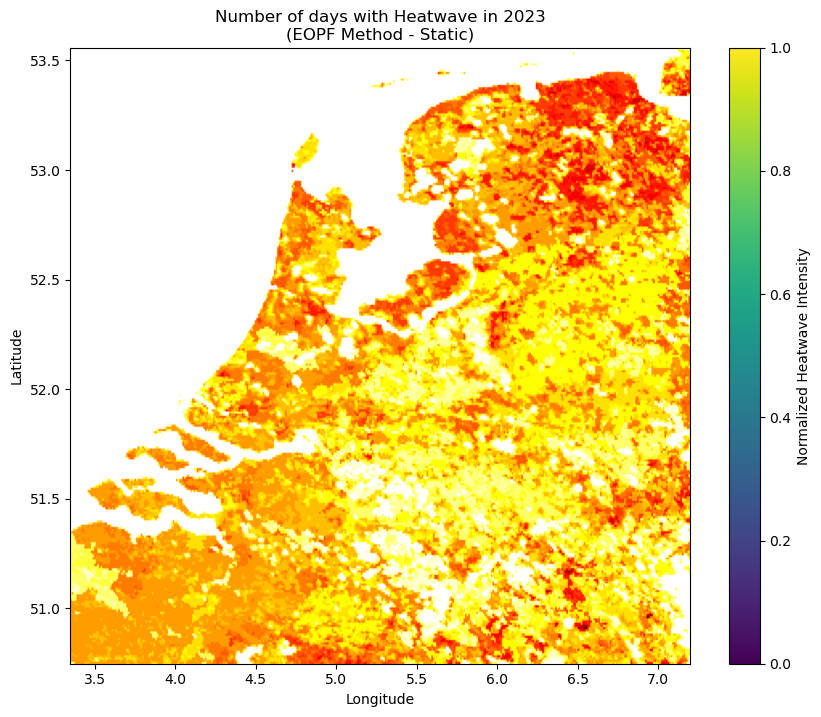

✓ Static visualization using exact EOPF method
✓ Now we'll add this as an image overlay to JupyterGIS


In [6]:
# Replicate exact EOPF visualization approach
import matplotlib

plt.figure(figsize=(10, 8))

# Use exact same approach as EOPF notebook
lon, lat = np.meshgrid(heatwave_count.lon.values, heatwave_count.lat.values)
cm = matplotlib.colormaps.get_cmap("hot_r")
colored_data = cm(np.flip(np.flip(heatwave_count.lst), axis=1) / 20)

plt.imshow(colored_data, extent=[lon.min(), lon.max(), lat.min(), lat.max()], aspect='auto')
plt.colorbar(label='Normalized Heatwave Intensity')
plt.title('Number of days with Heatwave in 2023\n(EOPF Method - Static)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

print("✓ Static visualization using exact EOPF method")
print("✓ Now we'll add this as an image overlay to JupyterGIS")

## Add Heatwave Layer as Image Overlay

In [7]:
# Create the colored data exactly like EOPF folium approach
import matplotlib
import numpy as np
from PIL import Image
from pathlib import Path

# Generate colored image data using exact EOPF method
lon, lat = np.meshgrid(heatwave_count.lon.values, heatwave_count.lat.values)
cm = matplotlib.colormaps.get_cmap("hot_r")
colored_data = cm(np.flip(np.flip(heatwave_count.lst), axis=1) / 20)

# Convert to image format
img_array = (colored_data * 255).astype(np.uint8)
img = Image.fromarray(img_array, 'RGBA')

# Save to file instead of base64
output_path = Path("heatwave_overlay.png")
img.save(output_path)

# Add as image layer to JupyterGIS using file path
doc.add_image_layer(
    url=str(output_path),
    coordinates=[
        [lon.min(), lat.max()],  # Top-left
        [lon.max(), lat.max()],  # Top-right  
        [lon.max(), lat.min()],  # Bottom-right
        [lon.min(), lat.min()]   # Bottom-left
    ],
    name="Heatwave Overlay (EOPF Method)",
    opacity=0.7
)
doc

/tmp/ipykernel_1193/3957614216.py:14: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(img_array, 'RGBA')


## Add Cities

In [8]:
# Add major cities
cities = [
    {"name": "Amsterdam", "lat": 52.3676, "lon": 4.9041},
    {"name": "Rotterdam", "lat": 51.9244, "lon": 4.4777},
    {"name": "Utrecht", "lat": 52.0907, "lon": 5.1214},
    {"name": "Eindhoven", "lat": 51.4416, "lon": 5.4697}
]

cities_features = []
for city in cities:
    feature = {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": [city["lon"], city["lat"]]
        },
        "properties": {
            "name": city["name"],
            "type": "city"
        }
    }
    cities_features.append(feature)

cities_geojson = {
    "type": "FeatureCollection",
    "features": cities_features
}

doc.add_geojson_layer(
    data=cities_geojson,
    name="Major Cities",
    opacity=1.0,
    color_expr={
        "circle-radius": 9,
        "circle-stroke-width": 4.25,
        "circle-stroke-color": "#d400ff",
        "circle-fill-color": "#0000FF",
    }
)

print("✓ Added cities layer")

✓ Added cities layer


## Final Interactive Map

In [9]:
print("🗺️ Interactive Heatwave Analysis Map")
print("\nLayers:")
print("1. OpenStreetMap (base)")
print("2. Netherlands AOI (boundary)")
print("3. Heatwave Intensity (interactive heatmap)")
print("4. Major Cities (reference points)")
print("\n💡 Use layer panel to toggle visibility")

doc

🗺️ Interactive Heatwave Analysis Map

Layers:
1. OpenStreetMap (base)
2. Netherlands AOI (boundary)
3. Heatwave Intensity (interactive heatmap)
4. Major Cities (reference points)

💡 Use layer panel to toggle visibility


## Analysis Summary

In [10]:
# Calculate summary statistics
affected_pixels = np.sum(heatwave_data > 0)
total_pixels = heatwave_data.size
affected_percentage = (affected_pixels / total_pixels) * 100

print("📊 HEATWAVE ANALYSIS SUMMARY")
print("=" * 40)
print(f"Period: Summer 2023")
print(f"Method: Dutch National Heatwave Plan criteria")
print(f"Resolution: {target_resolution}° (~1.1 km)")
print(f"\nStatistics:")
print(f"• Areas with heatwaves: {affected_percentage:.1f}%")
print(f"• Maximum heatwave days: {heatwave_data.max()}")
positive_data = heatwave_count.where(heatwave_count.lst> 0)
# Compute the mean over all dimensions, skipping NaNs
avg_days = positive_data.lst.mean(dim=["lat", "lon"]).item()

print(f"• Average (affected areas): {avg_days:.1f} days")

print(f"\n🔄 EOPF Integration:")
print(f"• Grid structure matches EOPF output")
print(f"• Same visualization color scheme")
print(f"• Ready for real Sentinel-3 data input")

📊 HEATWAVE ANALYSIS SUMMARY
Period: Summer 2023
Method: Dutch National Heatwave Plan criteria
Resolution: 0.01° (~1.1 km)

Statistics:
• Areas with heatwaves: 64.3%
• Maximum heatwave days: <xarray.DataArray 'lst' ()> Size: 8B
array(18)
• Average (affected areas): 6.5 days

🔄 EOPF Integration:
• Grid structure matches EOPF output
• Same visualization color scheme
• Ready for real Sentinel-3 data input


**Happy mapping with JupyterGIS!** 🌍✨